In [1]:
!pip install biosignalsnotebooks numpy scipy matplotlib

# Importar las bibliotecas necesarias
import biosignalsnotebooks as bsnb

from numpy import linspace, max, min, average, std, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy.signal import lfilter


In [2]:
def wavelet_denoising(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

In [8]:
# Load of data
data, header = bsnb.load("text_EMG.txt", get_header=True)

channel = list(data.keys())[0]
device = header["device"]
resolution = int(header["resolution"][0])

# Sampling frequency and acquired data
fs = header["sampling rate"]

# Signal Samples
signal = bsnb.raw_to_phy("EMG", device, data[channel], resolution, option="mV") # Conversion to mV
time = linspace(0, len(signal) / fs, len(signal))

# Aplica el filtrado con wavelet
emg_wavelet = wavelet_denoising(signal, wavelet='db4', level=3)

# Asignamos la señal filtrada a 'signal' para usarla en el procesamiento posterior
signal = emg_wavelet

burst_begin, burst_end = bsnb.detect_emg_activations(signal, fs, smooth_level=20, threshold_level=10,
                                                     time_units=True, plot_result=True)[:2]


In [10]:
# Bursts Duration
bursts_time = burst_end - burst_begin

# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)

print("Características de la duración de los bursts:")
for i, burst_duration in enumerate(bursts_time):
    print(f"Burst {i + 1}: {burst_duration} segundos")

print("\nParámetros estadísticos de la duración de los bursts:")
print(f"Max time: {max_time} segundos")
print(f"Min time: {min_time} segundos")
print(f"Average time: {avg_time} segundos")
print(f"Standard deviation: {std_time} segundos")

Características de la duración de los bursts:
Burst 1: 0.42102319687035106 segundos
Burst 2: 1.730095322056311 segundos

Parámetros estadísticos de la duración de los bursts:
Max time: 1.730095322056311 segundos
Min time: 0.42102319687035106 segundos
Average time: 1.075559259463331 segundos
Standard deviation: 0.6545360625929799 segundos



Parámetros de la señal EMG:
Maximum EMG: 187.32661564437595
Minimum EMG: -0.9466879949873217
Average EMG: 101.92024633840879
Standard Deviation EMG: 6.298139535666225


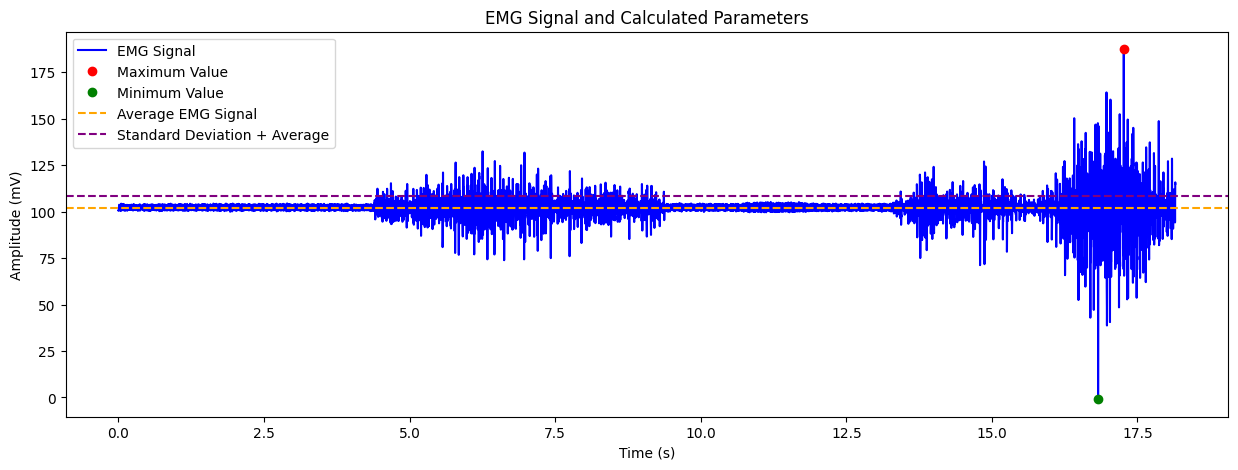

In [11]:
#Parámetros de la señal filtrada

# Maximum
max_sample_value = max(signal)
max_sample_index = np.argmax(signal)

# Minimum
min_sample_value = min(signal)
min_sample_index = np.argmin(signal)

# Average and Standard Deviation
avg_sample_value = average(signal)
std_sample_value = std(signal)

time_param_dict = {"Maximum EMG": max_sample_value, "Minimum EMG": min_sample_value,
                   "Average EMG": avg_sample_value, "Standard Deviation EMG": std_sample_value}

# Imprimir parámetros
print("\nParámetros de la señal EMG:")
for param, value in time_param_dict.items():
    print(f"{param}: {value}")

plt.figure(figsize=(15, 5))
plt.plot(time, signal, label='EMG Signal', color='blue')

# Grafica los parámetros calculados
plt.plot(time[max_sample_index], max_sample_value, 'ro', label='Maximum Value')
plt.plot(time[min_sample_index], min_sample_value, 'go', label='Minimum Value')
plt.axhline(avg_sample_value, color='orange', linestyle='--', label='Average EMG Signal')
plt.axhline(avg_sample_value + std_sample_value, color='purple', linestyle='--', label='Standard Deviation + Average')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('EMG Signal and Calculated Parameters')
plt.legend()
plt.show()

Root Mean Square: 102.11465700521514
Cumulative Area under the curve: 1849744.7854054654
Root Mean Square: 102.11465700521514
Area under the curve: 1849744.7854054654


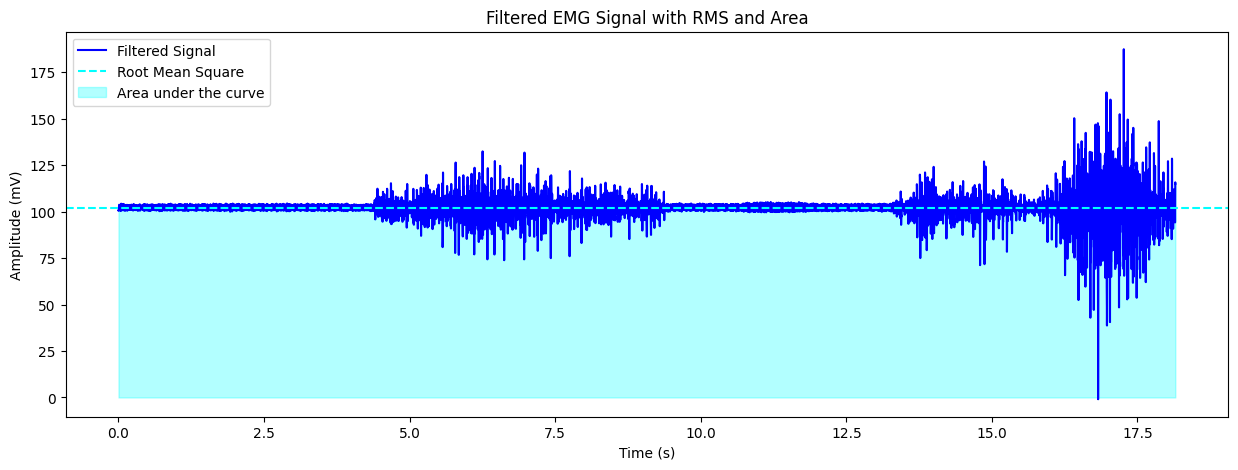

In [18]:
# Root Mean Square
rms = sqrt(sum(signal * signal) / len(signal))

# Area under the curve (cumulative)
area = cumtrapz(signal, initial=0)

# Imprimir los valores calculados
print("Root Mean Square:", rms)
print("Cumulative Area under the curve:", area_cumulative[-1])

# Imprimir los valores calculados
print("Root Mean Square:", rms)
print("Area under the curve:", area[-1])

# Graficar la señal filtrada, RMS y el área bajo la curva
plt.figure(figsize=(15, 5))
plt.plot(time, signal, label='Filtered Signal', color='blue')
plt.axhline(rms, color='cyan', linestyle='--', label='Root Mean Square')
plt.fill_between(time, signal, color='cyan', alpha=0.3, label='Area under the curve')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Filtered EMG Signal with RMS and Area')
plt.legend()
plt.show()

Total Power: 43.63991617034111
Median Frequency: 70.3125
Frequency of Maximum Power: 42.96875


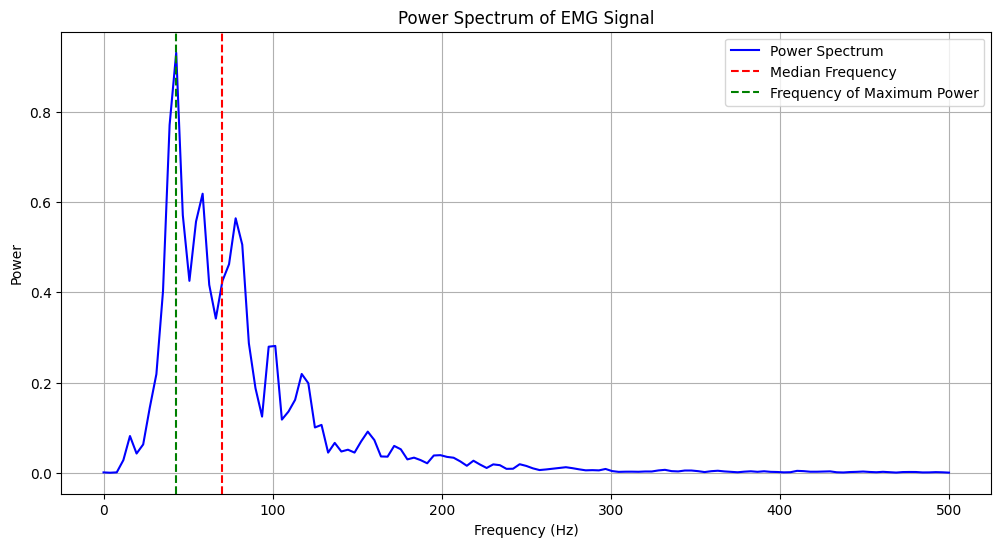

In [19]:
# Signal Power Spectrum
f, P = welch(signal, fs=fs, window='hanning', noverlap=0, nfft=int(256.))

# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(P, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(P)]

# Imprimir los valores
print("Total Power:", total_power)
print("Median Frequency:", median_freq)
print("Frequency of Maximum Power:", f_max)

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar el espectro de potencia
plt.plot(f, P, label='Power Spectrum', color='blue')

# Graficar la frecuencia mediana y la frecuencia máxima
plt.axvline(median_freq, color='red', linestyle='--', label='Median Frequency')
plt.axvline(f_max, color='green', linestyle='--', label='Frequency of Maximum Power')

# Añadir etiquetas y leyenda
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum of EMG Signal')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [20]:
bsnb.emg_parameters(signal, fs, raw_to_mv=False)

{'Number of Muscular Activations': 2,
 'Maximum Muscular Activation Duration': 1.730095322056311,
 'Minimum Muscular Activation Duration': 0.42102319687035106,
 'Average Muscular Activation Duration': 1.075559259463331,
 'Standard Deviation of Muscular Activation Duration': 0.6545360625929799,
 'Maximum Sample Value': 187.32661564437595,
 'Minimum Sample Value': -0.9466879949873217,
 'Average Sample Value': 101.92024633840879,
 'Standard Deviation Sample Value': 6.298139535666225,
 'RMS': 102.11465700521475,
 'Area': 1849744.7854054654,
 'Total Power Spect': 43.63991617034111,
 'Median Frequency': 70.3125,
 'Maximum Power Frequency': 42.96875}